Total Rows: 3,120,010
Fraud Count: 9,829
Fraud Rate: 0.3150%
Time Range: 2024-06-01 00:00:03.285000 to 2024-09-30 23:59:51.252000

Top 20 Missing Columns (%):
buyer_gsm                       10.556473
card_family                      2.957971
card_type                        2.957843
card_association                 2.933068
merchant_work_beginning_date     1.932750
payment_group                    0.004455
buyer_surname                    0.000353
payment_source_id                0.000321
buyer_city                       0.000128
buyer_name                       0.000096


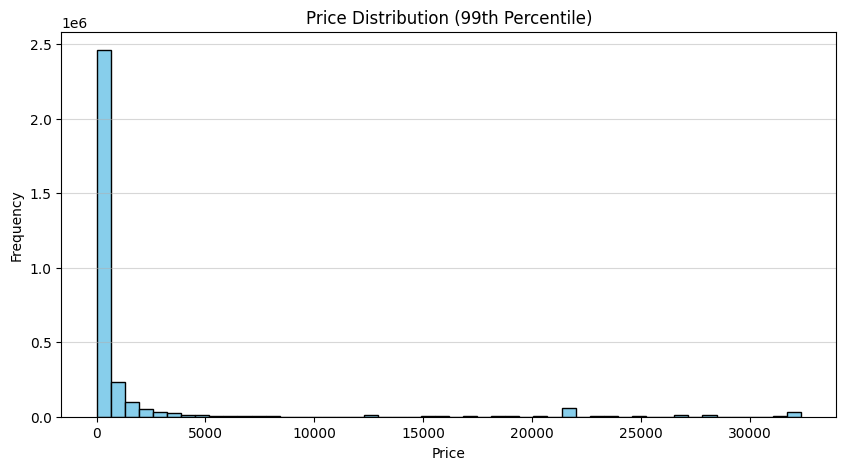

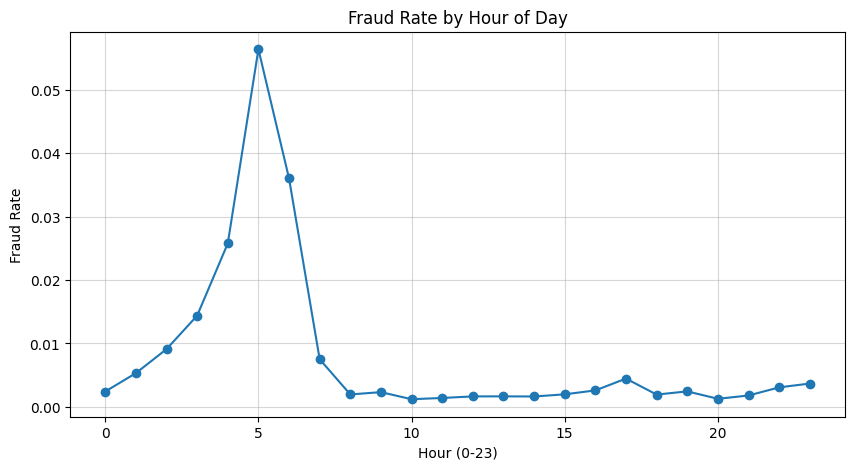

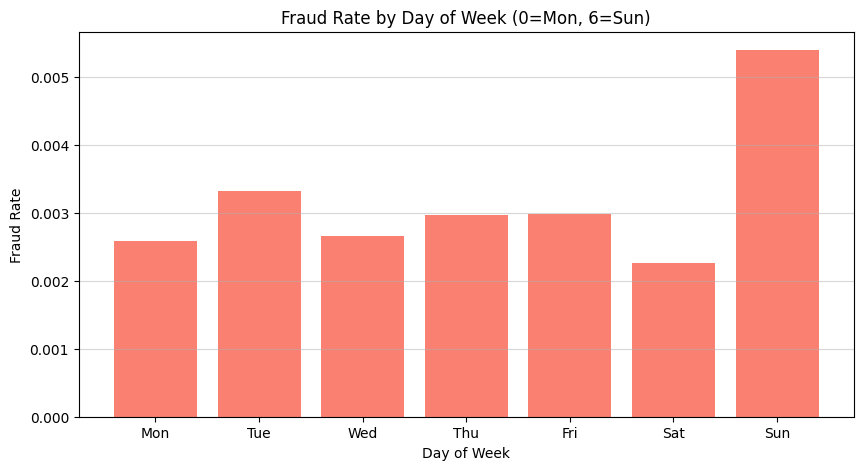

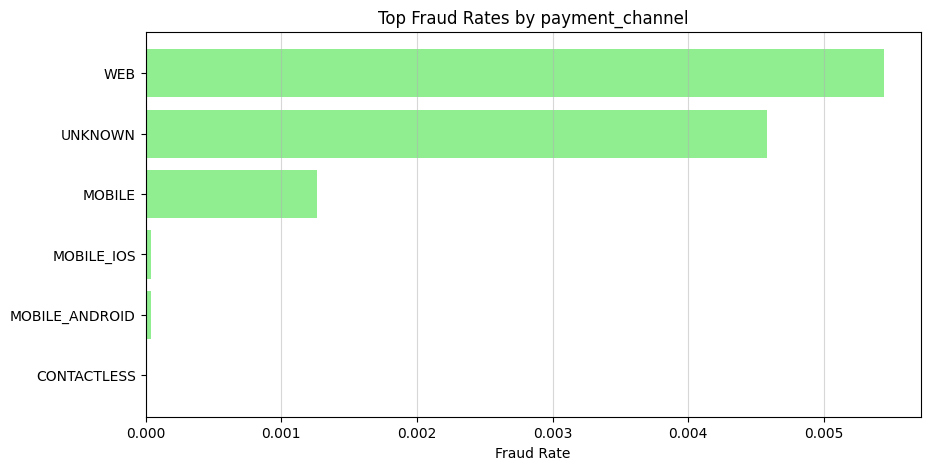

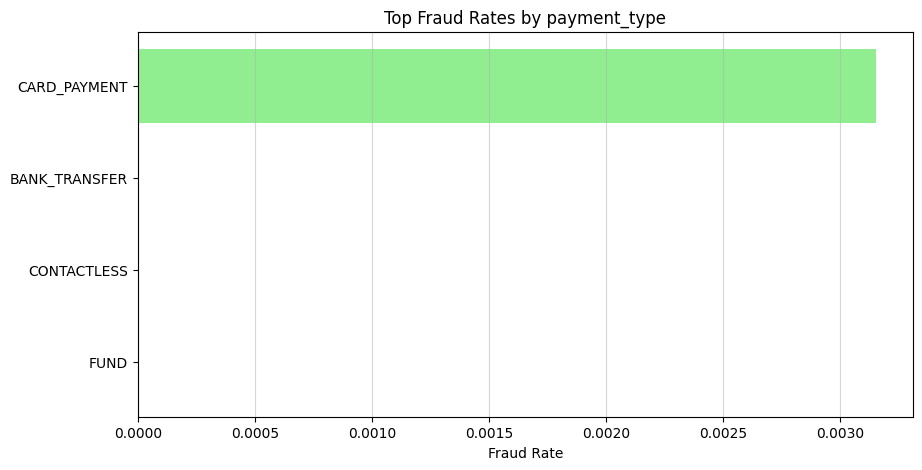

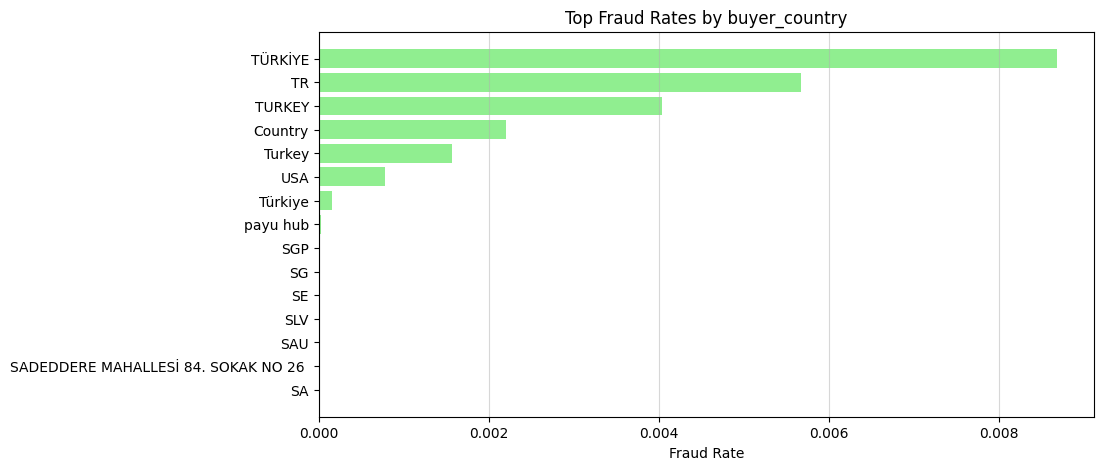

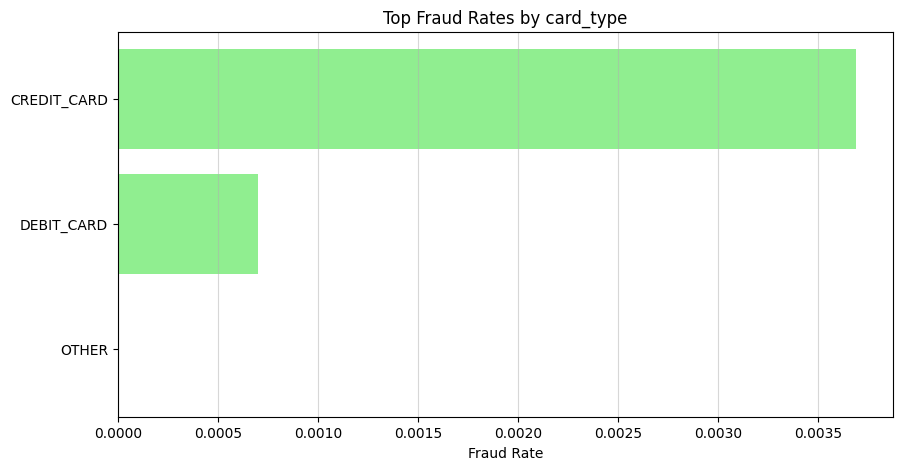

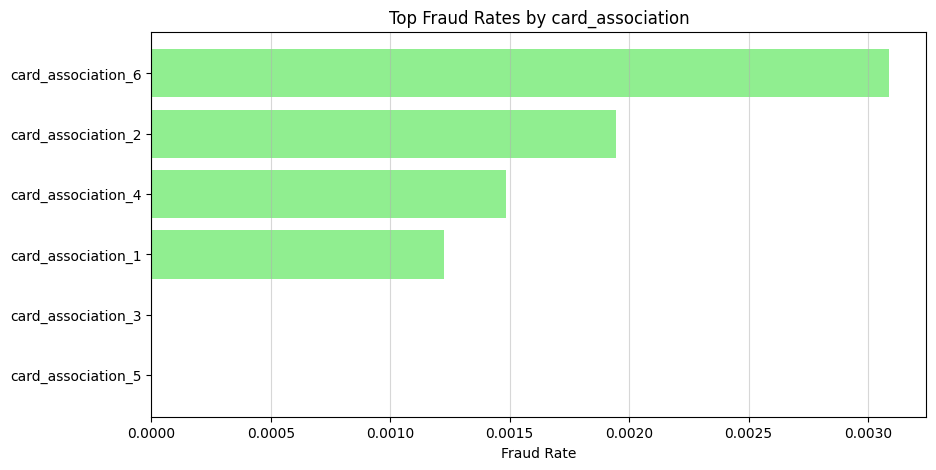

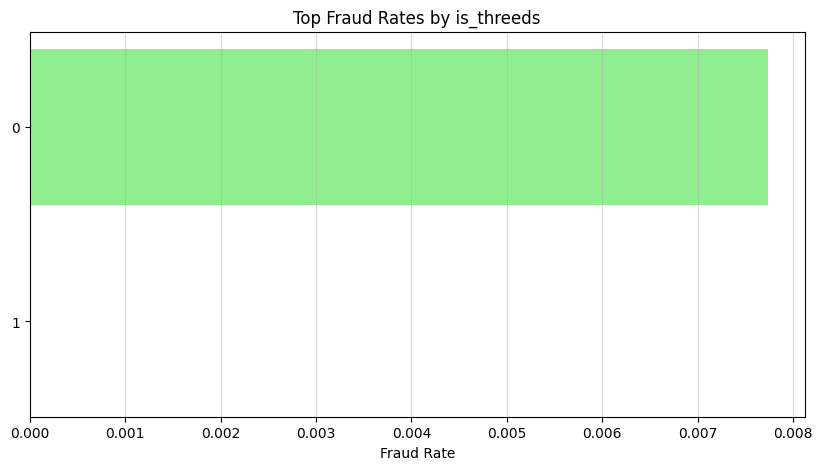


Summary saved to: ../data/processed/eda_summary.csv


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Display settings: Show all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1400)

# File paths
RAW_PATH = "../data/raw/iyzico_fraud_data.csv"
OUT_PATH = "../data/processed/eda_summary.csv"
TARGET = "is_fraud_transaction"

# Set these columns as strings to prevent reading errors
DTYPE_MAP = {
    "buyer_gsm": "string",
    "buyer_email": "string",
    "bin_number": "string",
    "last_four_digits": "string",
    "merchant_id": "string",
    "payment_source_id": "string",
}

# Read the CSV file
df = pd.read_csv(RAW_PATH, dtype=DTYPE_MAP, low_memory=False)

# Fix date format and remove rows with missing dates
df["payment_date"] = pd.to_datetime(df["payment_date"], errors="coerce")
df = df.dropna(subset=["payment_date"]).reset_index(drop=True)

# Convert price and target to numbers (fill missing with 0)
df["price"] = pd.to_numeric(df["price"], errors="coerce").fillna(0.0)
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

# --- Basic Stats ---
rows = len(df)
fraud_count = df[TARGET].sum()
fraud_rate = fraud_count / rows

print(f"Total Rows: {rows:,}")
print(f"Fraud Count: {fraud_count:,}")
print(f"Fraud Rate: {fraud_rate:.4%}")
print(f"Time Range: {df['payment_date'].min()} to {df['payment_date'].max()}")

# Check which columns have missing values
print("\nTop 20 Missing Columns (%):")
missing_vals = (df.isna().mean().sort_values(ascending=False) * 100).head(20)
print(missing_vals[missing_vals > 0].to_string())

# --- Visualizations ---

# 1. Plot Price Distribution (remove extreme values for better view)
plt.figure(figsize=(10, 5))
plt.hist(df["price"].clip(upper=df["price"].quantile(0.99)), bins=50, color='skyblue', edgecolor='black')
plt.title("Price Distribution (99th Percentile)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.5)
plt.show()

# Create time features (Hour and Day of Week)
df["txn_hour"] = df["payment_date"].dt.hour
df["txn_dow"] = df["payment_date"].dt.dayofweek

# 2. Plot Fraud Rate by Hour
hour_fraud = df.groupby("txn_hour")[TARGET].mean()
plt.figure(figsize=(10, 5))
plt.plot(hour_fraud.index, hour_fraud.values, marker='o', linestyle='-')
plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour (0-23)")
plt.ylabel("Fraud Rate")
plt.grid(True, alpha=0.5)
plt.show()

# 3. Plot Fraud Rate by Day of Week
dow_fraud = df.groupby("txn_dow")[TARGET].mean()
plt.figure(figsize=(10, 5))
plt.bar(dow_fraud.index, dow_fraud.values, color='salmon')
plt.title("Fraud Rate by Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Fraud Rate")
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(axis='y', alpha=0.5)
plt.show()

# 4. Analyze Categories
# Check fraud rates for specific categorical columns
cat_cols = ["payment_channel", "payment_type", "buyer_country",
            "card_type", "card_association", "is_threeds"]

for c in cat_cols:
    if c in df.columns:
        # Get top 15 categories with highest fraud rate
        stats = df.groupby(c)[TARGET].mean().sort_values(ascending=False).head(15)

        plt.figure(figsize=(10, 5))
        plt.barh(stats.index.astype(str), stats.values, color='lightgreen')
        plt.title(f"Top Fraud Rates by {c}")
        plt.xlabel("Fraud Rate")
        plt.gca().invert_yaxis() # Put highest rate at the top
        plt.grid(axis='x', alpha=0.5)
        plt.show()

# Save the results to a CSV file
eda_summary = pd.DataFrame({
    "total_rows": [rows],
    "fraud_rate": [fraud_rate],
    "start_date": [df["payment_date"].min()],
    "end_date": [df["payment_date"].max()]
})
eda_summary.to_csv(OUT_PATH, index=False)
print(f"\nSummary saved to: {OUT_PATH}")